# Deep dive into results

Analysing what the true positive rate for the predictions is.

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load datasets

In [2]:
euos_df_predictions = pd.read_csv("../data/predictions/combined_euos_predictions.csv")
euos_df_predictions.head(2)

,Unnamed: 0,eos,Fungi_candida,Fungi_aspergillus,Fungi_candida_auris,Gram_positive_staph,Gram_positive_enterococcus,smiles,inchikey,gram_negative,final_class,mhfp6,prediction,probability
0,2478,EOS102228,inactive,inactive,inactive,inactive,inactive,Cl.Cl.NCCCCCCCCN,ZFLWZOGXFQNIMT-UHFFFAOYSA-N,inactive,inactive,[461248215 33988699 706189559 ... 231087554 ...,acid-fast,1.000000
1,789,EOS100708,inconclusive,active,active,inactive,inactive,CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12.Cl,BWMISRWJRUSYEX-SZKNIZGXSA-N,inactive,fungi,[123358859 33988699 63689098 ... 21856680 1...,fungi,0.999477


In [3]:
# draw donut plot on predictions
pred_classes = euos_df_predictions["prediction"].value_counts()
pred_sizes = pred_classes.values
pred_labels = pred_classes.index

true_classes = euos_df_predictions["final_class"].value_counts()
true_sizes = true_classes.values
true_labels = true_classes.index

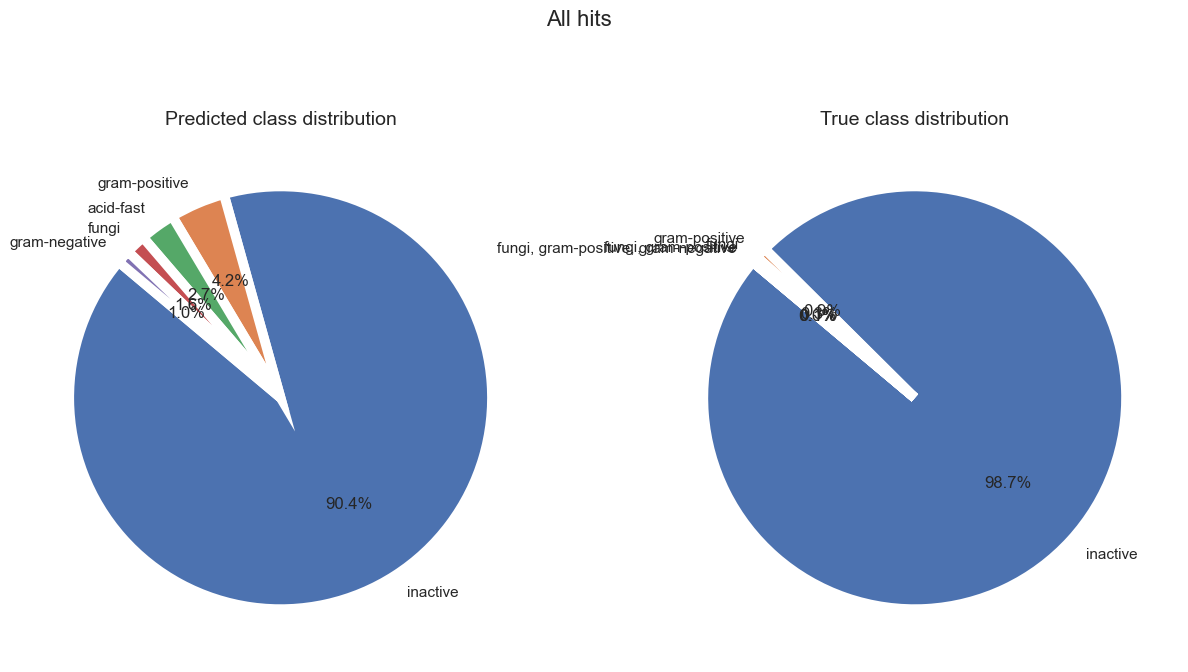

In [4]:
# Create a pieplot
fig = plt.figure(figsize=(15, 8))
plt.suptitle(f"All hits", fontsize=16)


ax1 = fig.add_subplot(121)
ax1.pie(
    pred_sizes,
    labels=pred_labels,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"linewidth": 7, "edgecolor": "white"},
)
ax1.set_title("Predicted class distribution", fontsize=14)

ax2 = fig.add_subplot(122)
ax2.pie(
    true_sizes,
    labels=true_labels,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"linewidth": 7, "edgecolor": "white"},
)
ax2.set_title("True class distribution", fontsize=14)

plt.show()

# Looking into predictions

In [5]:
def get_pred_overlap(df: pd.DataFrame, threshold: float = 0.5):
    k = df[df["probability"] >= threshold]

    corrected_predicted = []
    incorrect_predicted = []

    for idx, pred, final in k[["eos", "prediction", "final_class"]].values:
        if pred in final:
            corrected_predicted.append(idx)
        else:
            incorrect_predicted.append(idx)

    # pie chart
    labels = "Correctly Predicted", "Incorrectly Predicted"
    sizes = [len(corrected_predicted), len(incorrect_predicted)]
    explode = (0.1, 0)  # explode 1st slice

    fig1, ax1 = plt.subplots()
    ax1.pie(
        sizes,
        explode=explode,
        labels=labels,
        autopct="%1.1f%%",
        shadow=True,
        startangle=90,
    )
    ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(
        f"Correct vs Incorrect Predictions at threshold {threshold} (compounds: {len(k)})"
    )
    plt.show()

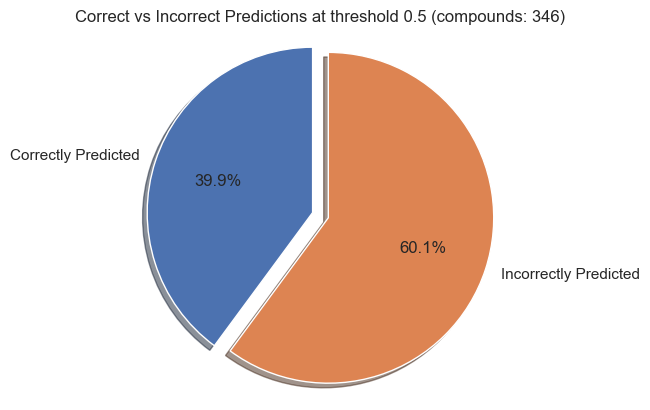

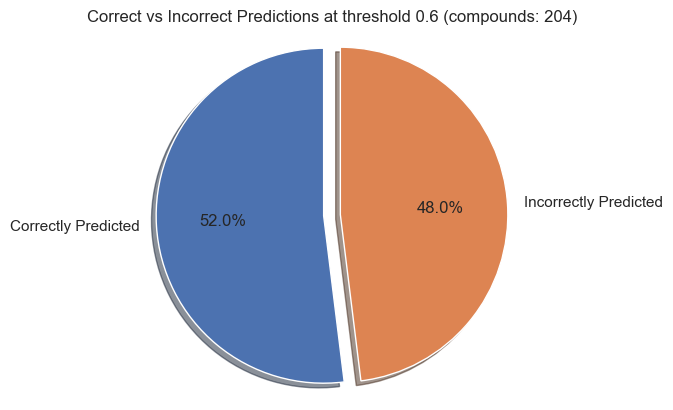

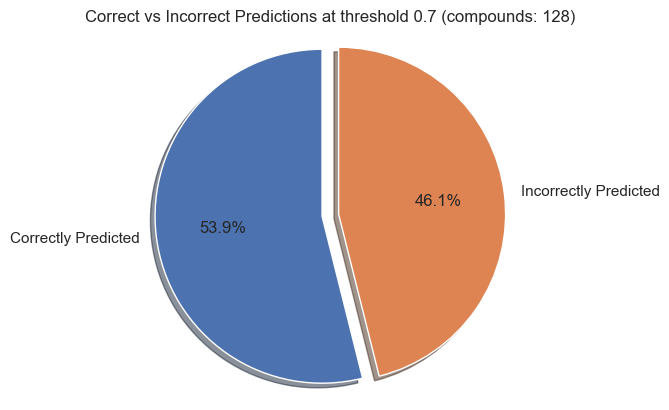

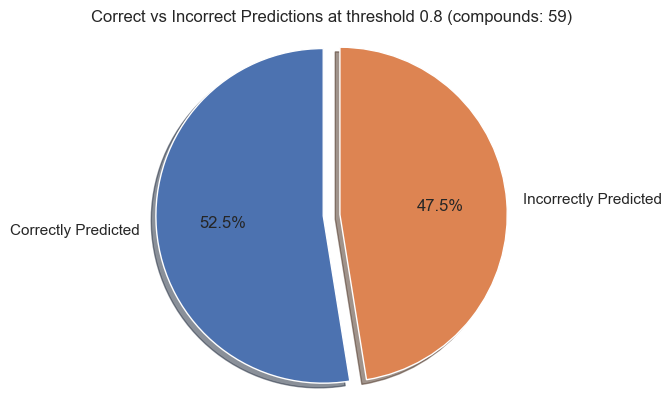

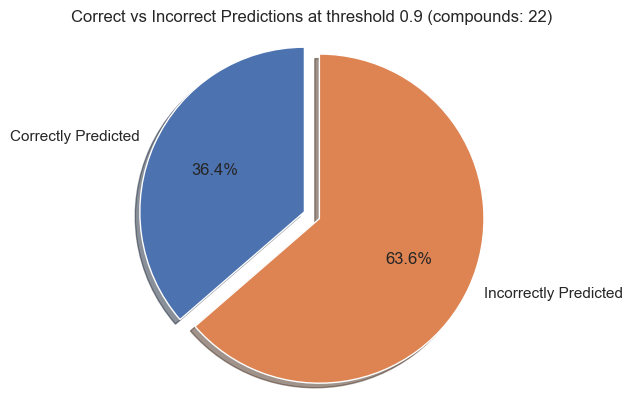

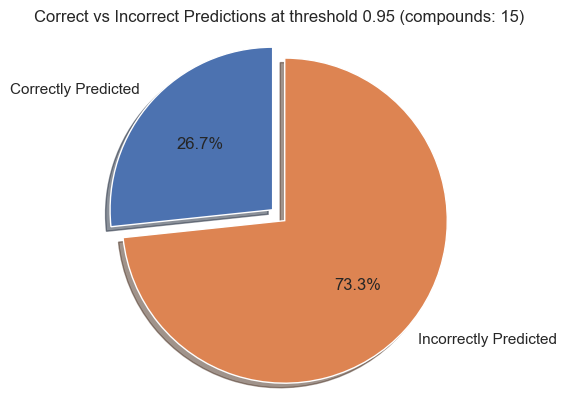

In [6]:
for sim in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    get_pred_overlap(df=euos_df_predictions, threshold=sim)

# Scatterplot of cosine similarity vs model predictions

In [7]:
true_predictions = []

for final_class, prediction in tqdm(
    euos_df_predictions[["final_class", "prediction"]].values
):
    if prediction in final_class:
        true_predictions.append("yes")
    else:
        true_predictions.append("no")

euos_df_predictions["true_prediction"] = true_predictions

100%|██████████| 101024/101024 [00:00<00:00, 2302167.11it/s]


# Confusion matrices

In [8]:
def generate_confusion_matrix(threshold: float = 0, plot: bool = True):
    true_classes = {
        "fungi": set(),
        "gram-positive": set(),
        "gram-negative": set(),
        "acid-fast": set(),
        "inactive": set(),
    }
    predicted_classes = {
        "fungi": set(),
        "gram-positive": set(),
        "gram-negative": set(),
        "acid-fast": set(),
        "inactive": set(),
    }

    tmp_df = euos_df_predictions[euos_df_predictions["probability"] >= threshold]

    for idx, final_class, prediction in tqdm(
        tmp_df[["eos", "final_class", "prediction"]].values
    ):
        predicted_classes[prediction].add(idx)
        for c in final_class.split(", "):
            true_classes[c].add(idx)

    # generate confusion matrix
    confusion_matrix = {
        "fungi": {
            "fungi": len(predicted_classes["fungi"] & true_classes["fungi"]),
            "gram-positive": len(
                predicted_classes["fungi"] & true_classes["gram-positive"]
            ),
            "gram-negative": len(
                predicted_classes["fungi"] & true_classes["gram-negative"]
            ),
            "acid-fast": len(predicted_classes["fungi"] & true_classes["acid-fast"]),
            "inactive": len(predicted_classes["fungi"] & true_classes["inactive"]),
        },
        "gram-positive": {
            "fungi": len(predicted_classes["gram-positive"] & true_classes["fungi"]),
            "gram-positive": len(
                predicted_classes["gram-positive"] & true_classes["gram-positive"]
            ),
            "gram-negative": len(
                predicted_classes["gram-positive"] & true_classes["gram-negative"]
            ),
            "acid-fast": len(
                predicted_classes["gram-positive"] & true_classes["acid-fast"]
            ),
            "inactive": len(
                predicted_classes["gram-positive"] & true_classes["inactive"]
            ),
        },
        "gram-negative": {
            "fungi": len(predicted_classes["gram-negative"] & true_classes["fungi"]),
            "gram-positive": len(
                predicted_classes["gram-negative"] & true_classes["gram-positive"]
            ),
            "gram-negative": len(
                predicted_classes["gram-negative"] & true_classes["gram-negative"]
            ),
            "acid-fast": len(
                predicted_classes["gram-negative"] & true_classes["acid-fast"]
            ),
            "inactive": len(
                predicted_classes["gram-negative"] & true_classes["inactive"]
            ),
        },
        "acid-fast": {
            "fungi": len(predicted_classes["acid-fast"] & true_classes["fungi"]),
            "gram-positive": len(
                predicted_classes["acid-fast"] & true_classes["gram-positive"]
            ),
            "gram-negative": len(
                predicted_classes["acid-fast"] & true_classes["gram-negative"]
            ),
            "acid-fast": len(
                predicted_classes["acid-fast"] & true_classes["acid-fast"]
            ),
            "inactive": len(predicted_classes["acid-fast"] & true_classes["inactive"]),
        },
        "inactive": {
            "fungi": len(predicted_classes["inactive"] & true_classes["fungi"]),
            "gram-positive": len(
                predicted_classes["inactive"] & true_classes["gram-positive"]
            ),
            "gram-negative": len(
                predicted_classes["inactive"] & true_classes["gram-negative"]
            ),
            "acid-fast": len(predicted_classes["inactive"] & true_classes["acid-fast"]),
            "inactive": len(predicted_classes["inactive"] & true_classes["inactive"]),
        },
    }
    confusion_matrix = pd.DataFrame.from_dict(confusion_matrix)

    # normalize confusion matrix column
    confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)
    confusion_matrix.fillna(0, inplace=True)

    if plot:
        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.xlabel("Predicted")
        plt.ylabel("Tested class")
        plt.title(
            f"Confusion matrix on {len(tmp_df)} compounds at threshold >= {threshold}"
        )
        plt.show()
    else:
        return confusion_matrix

100%|██████████| 101024/101024 [00:00<00:00, 1775026.15it/s]


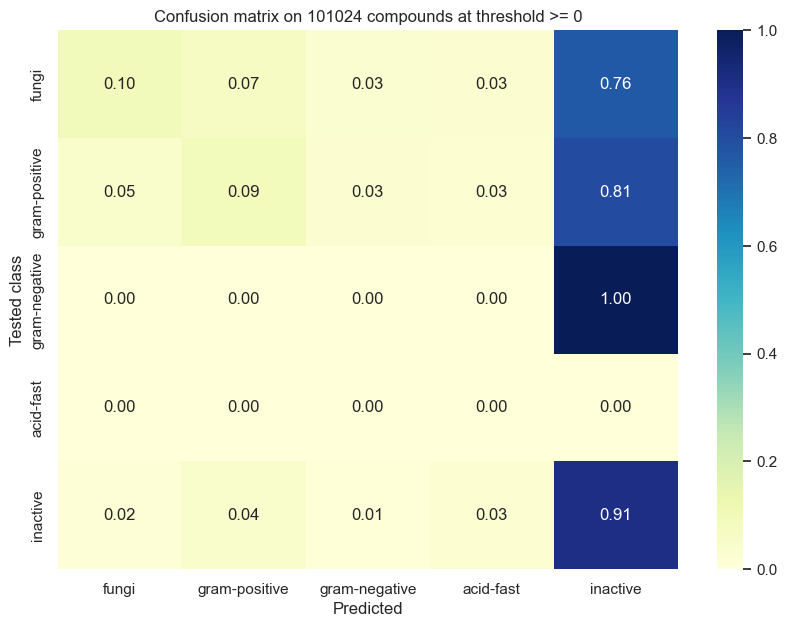

In [9]:
generate_confusion_matrix()

100%|██████████| 204/204 [00:00<00:00, 420667.66it/s]


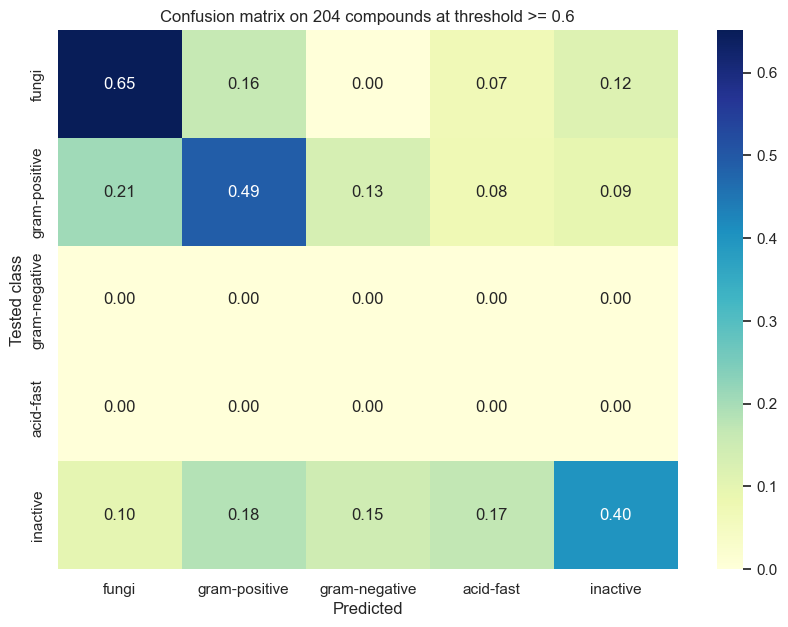

In [10]:
generate_confusion_matrix(threshold=0.6)

100%|██████████| 128/128 [00:00<00:00, 458864.03it/s]


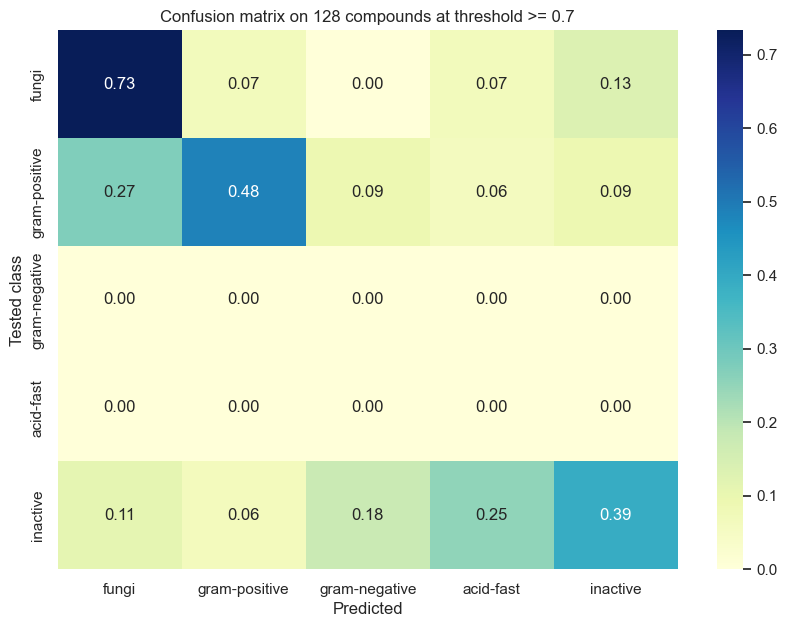

In [11]:
generate_confusion_matrix(threshold=0.7)

100%|██████████| 204/204 [00:00<00:00, 1360314.81it/s]


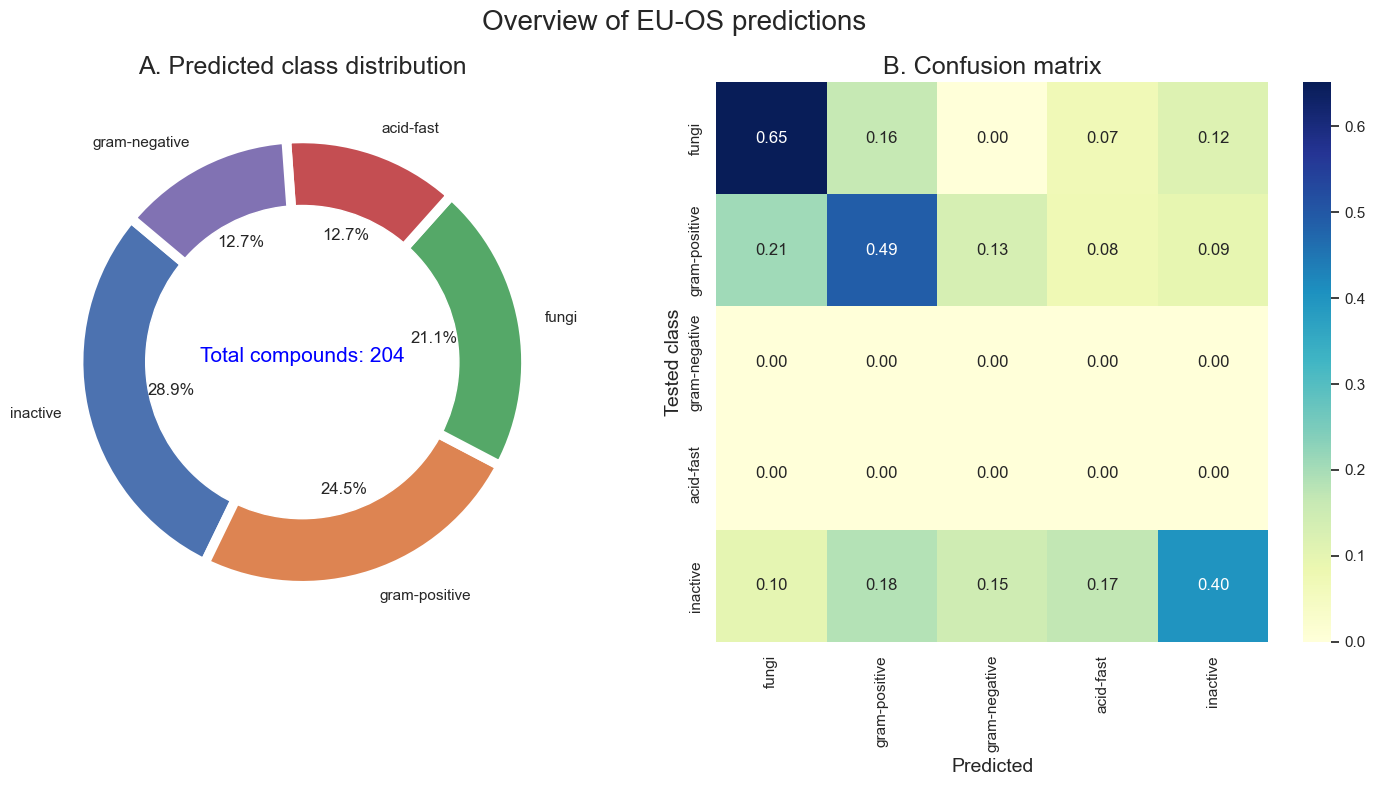

In [12]:
# Create a pieplot
fig = plt.figure(figsize=(15, 8))
plt.suptitle(f"Overview of EU-OS predictions", fontsize=20)

k = euos_df_predictions[euos_df_predictions["probability"] >= 0.6][
    "prediction"
].value_counts()

ax1 = fig.add_subplot(121)
ax1.pie(
    k.values,
    labels=k.index,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"linewidth": 7, "edgecolor": "white"},
)

# add a circle at the center to transform it in a donut chart
my_circle = plt.Circle((0, 0), 0.7, color="white")
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.text(
    0,
    0,
    f"Total compounds: {len(euos_df_predictions[euos_df_predictions['probability'] >= 0.6])}",
    ha="center",
    fontsize=15,
    color="blue",
)
ax1.set_title("A. Predicted class distribution", fontsize=18)

ax1 = fig.add_subplot(122)
m = generate_confusion_matrix(threshold=0.6, plot=False)
sns.heatmap(m, annot=True, cmap="YlGnBu", fmt=".2f")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Tested class", fontsize=14)
plt.title("B. Confusion matrix", fontsize=18)
plt.tight_layout()
plt.savefig("../figures/figure_8.png", dpi=400)
plt.show()